In [5]:
!git clone --depth 1 https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 1), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 1.53 MiB | 4.10 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Installing konlpy.....
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 40.2 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-05-20 00:25:38--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.142.24, 104.192.142.26, 104.192.142.25, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.142.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: ht

In [6]:
!pip install mecab-python3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 12.1 MB/s eta 0:00:00


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

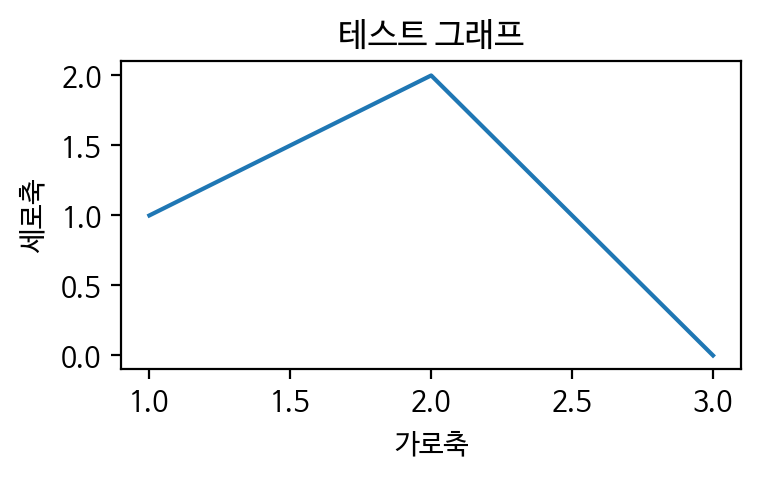

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# retina display (for better rendering in notebooks)
%config InlineBackend.figure_format = 'retina'

# 폰트 목록 확인
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
nanum_font_path = [f for f in font_list if 'NanumBarunGothic' in f]

# 경로 확인 및 설정
if nanum_font_path:
    nanum_font = fm.FontProperties(fname=nanum_font_path[0])
    plt.rc('font', family=nanum_font.get_name())
else:
    print("NanumBarunGothic not found")

# 마이너스 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

# 테스트
plt.figure(figsize=(4, 2))
plt.title("테스트 그래프")
plt.plot([1, 2, 3], [1, 2, 0])
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.show()

In [2]:
!pip install word2number

In [3]:
!pip install nltk

In [4]:
import pandas as pd
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io
from tensorflow.keras.preprocessing.text import Tokenizer
from konlpy.tag import Mecab
from tqdm.notebook import tqdm
import random

seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
import tarfile

with tarfile.open('korean-english-park.train.tar.gz', 'r:gz') as tar:
  tar.extractall()
with tarfile.open('korean-english-park.test.tar.gz', 'r:gz') as tar:
  tar.extractall()

In [6]:
with open('/content/korean-english-park.train.ko', "r") as f:
  train_ko= f.read().splitlines()
with open('/content/korean-english-park.train.en', "r") as f:
  train_en= f.read().splitlines()
with open('/content/korean-english-park.test.ko', "r") as f:
  test_ko= f.read().splitlines()
with open('/content/korean-english-park.test.en', "r") as f:
  test_en= f.read().splitlines()

In [7]:
train=pd.DataFrame({'ko':train_ko,'en':train_en})
test=pd.DataFrame({'ko':test_ko,'en':test_en})

In [8]:
for i in [train,test]:
  i.drop_duplicates(subset='ko', inplace=True)
  i.drop_duplicates(subset='en', inplace=True)
  i.reset_index(drop=True, inplace=True)

In [9]:
len(train), len(test)

(74849, 1941)

실험개요

1. tokenizer의 vocabsize는 oov 존재하는 정도에서 고정
2. OOV replace 후처리,
3. 동일한 gru 조건에서 attention mechanism 차이에 따른 성능비교
4. 데이터셋의 품질이 안좋음. 한글 기자이름 영어 기사내용영어 , 한글 영어예문 설명 영어 예문만 한글에 없는정보 영어에, 영어에 없는정보 한글에, 아예 다른 내용 등 노이즈가 많음 -> cleaning

클리닝
1. 한글에는 숫자가 없는데 영어에만 숫자가 있는 샘플 다 제거 : 한글 35를 thirty five라고 쓰긴해도 한글에서 삼십오라고 쓰는경우 매우 드뭄. -> 없는 정보를 생성한 문장들 제거
2. 한국어 칼럼에 한국어와 영어가 동시에 나오거나 영어만 있는 경우 다 제거, 한국어 영어가 같이 나오는 경우는 영어단어 설명이나 문법설명인 경우 다수 존재
3. 정상 칼럼도 있지만 노이즈가 더 크다고 판단해서 다 제거

전처리
1. () 괄호안에 있는 내용 괄호포함해서 제거
2. 링크 제거
3. cf) 제거
4. 1. 2. 3. 이런 노이즈 제거
5. 구두점 제거 -> 번역에 문맥파악에 도움이 되기보단 불필요한 노이즈라 판단, 애초에 대부분의 문장이 한 문장 수준이라 크게 도움이 될 것 같지 않음
6. apostrophe 제거하지 않음
7. 숫자 , num 토큰 사용 후 oov와 같이 replace 수행

#0.클리닝

In [10]:
def has_digit(text):
    return bool(re.search(r'\d', str(text)))

ko_has_num = train['ko'].apply(has_digit)
en_has_num = train['en'].apply(has_digit)

both_have = (ko_has_num & en_has_num).sum()
only_ko = (ko_has_num & ~en_has_num).sum()
only_en = (~ko_has_num & en_has_num).sum()
either_has = (ko_has_num | en_has_num).sum()

print("① ko와 en 모두 숫자 포함:", both_have)
print("② ko만 숫자 포함:", only_ko)
print("③ en만 숫자 포함:", only_en)
print("④ ko 또는 en 중 하나라도 숫자 포함:", either_has)

① ko와 en 모두 숫자 포함: 19841
② ko만 숫자 포함: 12981
③ en만 숫자 포함: 1319
④ ko 또는 en 중 하나라도 숫자 포함: 34141


In [9]:
ko_has_num = test['ko'].apply(has_digit)
en_has_num = test['en'].apply(has_digit)

both_have = (ko_has_num & en_has_num).sum()
only_ko = (ko_has_num & ~en_has_num).sum()
only_en = (~ko_has_num & en_has_num).sum()
either_has = (ko_has_num | en_has_num).sum()

print("① ko와 en 모두 숫자 포함:", both_have)
print("② ko만 숫자 포함:", only_ko)
print("③ en만 숫자 포함:", only_en)
print("④ ko 또는 en 중 하나라도 숫자 포함:", either_has)

① ko와 en 모두 숫자 포함: 566
② ko만 숫자 포함: 303
③ en만 숫자 포함: 49
④ ko 또는 en 중 하나라도 숫자 포함: 918


In [11]:
ko_has_num = train['ko'].apply(has_digit)
en_has_num = train['en'].apply(has_digit)
mask_only_en = (~ko_has_num) & (en_has_num)

train = train[~mask_only_en].reset_index(drop=True)

In [12]:
ko_has_num = test['ko'].apply(has_digit)
en_has_num = test['en'].apply(has_digit)
mask_only_en = (~ko_has_num) & (en_has_num)

test = test[~mask_only_en].reset_index(drop=True)

In [13]:
len(train), len(test)

(73530, 1892)

In [14]:
def ko_and_en_or_only_en(text):
  if not isinstance(text, str):
      return False
  has_korean = bool(re.search(r'[가-힣]', text))
  has_english = bool(re.search(r'[a-zA-Z]', text))
  return (has_korean and has_english) or (not has_korean and has_english)

both_ko_en = train['ko'].apply(ko_and_en_or_only_en)

train_with_ko_en = train[both_ko_en].reset_index(drop=True)

In [125]:
train_with_ko_en['ko'][13045]

'back down 후퇴, 철회'

In [126]:
train_with_ko_en['en'][13045]

'On Tuesday, Lee and Park made it clear they will not back down over the primary rules.'

In [128]:
train_with_ko_en.tail(5)

,ko,en
13151,"E-1, 선거일까지 단 하루가 더 남았는데요, 마지막 하루 남은 선거운동이 진행되고...","It's E-1, just one more day until Election Day..."
13152,오늘 아침 사라 페일린 공화당 부통령 후보가 클레블랜드 외곽에서 공호당원들의 결집을...,With Sarah Palin rallying Republicans this mor...
13153,AP 통신의 워렌 레빈슨 기자가 생생한 소식을 전합니다.,"Right now, McCain seems full of energy in Tamp..."
13154,N.K. demands reactor first before dismantling ...,""""" South Korean Unification Minister Chung Don..."
13155,BBC의 찰스 스캔론 특파원은 북측의 이러한 발언이 지속되고 있는 교착 상태에서 벗...,The BBC's Charles Scanlon says that the North'...


In [15]:
mask_train = train['ko'].apply(ko_and_en_or_only_en)
mask_test = test['ko'].apply(ko_and_en_or_only_en)

train=train[~mask_train].reset_index(drop=True)
test=test[~mask_test].reset_index(drop=True)

In [16]:
len(train), len(test)

(60374, 1542)

In [17]:
from word2number import w2n

def replace_number_phrases(text):
  try:
    return str(w2n.word_to_num(text))  # "nineteen ninety" -> "1990"
  except:
    return text

In [45]:
replace_number_phrases('twenty five')

'25'

In [80]:
targets = ['1/2']

# 소문자 처리 후 포함 여부 확인
mask = train['ko'].str.lower().apply(lambda x: any(t in x for t in targets))

# 해당 문장들 출력 또는 저장
matched_sentences = train[mask]
print(matched_sentences)

                                                      ko  \
10102               그 다음 물 1/2컵에 식초 1/4컵을 썩어 중화시킨 후 말린다.   
51350  경기가 6회에서 양팀이 2-2 동점이 가운데 폭우로 인해 서스펜디드 경기가 선언됐고...   

                                                      en  
10102  Then you can go in to neutralize it with about...  
51350  It was among the wackiest endings in baseball ...  


In [79]:
targets = ['1/2']

# 소문자 처리 후 포함 여부 확인
mask = train['en'].str.lower().apply(lambda x: any(t in x for t in targets))
mask = train['en'].str.lower().apply(lambda x: any(t in x.split() for t in targets))

# 해당 문장들 출력 또는 저장
matched_sentences = train[mask]
print(matched_sentences)

                                                      ko  \
24832     달러-엔 환율은 26일 2년 6개월 만에 최저치인 107.28엔에 거래되기도 했다.   
32933  길을 따라 걷다 보면 수영을 할 수 있는 곳이 많으며 경치가 아름다워 사진을 촬영하...   
36544  부시 대통령은 메릴랜드 캠프 데이비드 별장에서 약 2시간 반동안 정기 검진을 받기로...   
36913  반면 패트릭 피츠제럴드 수석 검사는 “징역 15년 반에서 20년은 최소한의 형량”이...   
51350  경기가 6회에서 양팀이 2-2 동점이 가운데 폭우로 인해 서스펜디드 경기가 선언됐고...   

                                                      en  
24832  It fell to &yen; 107.28 yen earlier, its lowes...  
32933  the walk back will take about 3 1/2 hours, lea...  
36544  Bush is scheduled to have the medical procedur...  
36913  At a later press conference, Patrick Fitzgeral...  
51350  It was among the wackiest endings in baseball ...  


#1.전처리

In [18]:
def normalize_number(sentence):
  tokens = sentence.split()
  numeric_idxs = []

  for i, tok in enumerate(tokens):
    try:
      _ = w2n.word_to_num(tok)
      numeric_idxs.append(i)
    except:
      continue

  spans = []
  if numeric_idxs:
    start = numeric_idxs[0]
    prev = numeric_idxs[0]
    for idx in numeric_idxs[1:]:
      if idx == prev + 1:
        prev = idx
      else:
        spans.append((start, prev))
        start = idx
        prev = idx
    spans.append((start, prev))

  result=[]
  i = 0
  span_idx = 0

  while i < len(tokens):
    if span_idx < len(spans) and spans[span_idx][0] == i:
      start, end = spans[span_idx]
      span_text = ' '.join(tokens[start:end + 1])
      try:
        num = str(w2n.word_to_num(span_text))
        result.append(num)
      except:
        result.extend(tokens[start:end + 1])
      i = end + 1
      span_idx += 1
    else:
      result.append(tokens[i])
      i += 1

  return ' '.join(result)

In [19]:
def extract_number_mapping(sentence):
  # pattern = r'\b(\d+(?:[.,]\d+)?%?|\d+/\d+)\b'
  # pattern = r'\b(\d+(?:[.,]\d+)*%?|\d+/\d+)\b'
  pattern = r'(\d+(?:[.,]\d+)*%?|\d+/\d+)'
  mapping = {}

  for i, match in enumerate(re.finditer(pattern, sentence)):
      mapping[i] = match.group()

  return mapping

In [20]:
def preprocess_kr(sentence, replace=False, s_token=False, e_token=False):
  sentence = sentence.lower().strip()

  sentence = re.sub(r'\(.*?\)', '', sentence)
  sentence = re.sub(r'https?://\S+|www\.\S+', '', sentence)
  sentence = re.sub(r'\bcf\)', '', sentence)
  sentence = re.sub(r'\b\d{1,2}\.\s+', '', sentence)
  sentence = re.sub(r"([?!])", r" \1 ", sentence)

  sentence = sentence.replace('-', ' ')
  sentence = re.sub(r'[<>]', '', sentence)
  sentence = normalize_number(sentence)

  if replace:
    mapping = extract_number_mapping(sentence)
  sentence = re.sub(r'(\d+(?:[.,]\d+)*%?|\d+/\d+)', ' <숫자> ', sentence)

  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = re.sub(r"[^가-힣<>?!]+", " ", sentence)

  sentence = sentence.strip()

  if s_token:
    sentence = '<start> ' + sentence

  if e_token:
    sentence += ' <end>'

  if replace:
    return sentence, mapping

  return sentence

In [21]:
def preprocess_en(sentence, replace=False, s_token=False, e_token=False):
  sentence = sentence.lower().strip()

  sentence = re.sub(r'\(.*?\)', '', sentence)
  sentence = re.sub(r'https?://\S+|www\.\S+', '', sentence)
  sentence = re.sub(r'\bcf\)', '', sentence)
  sentence = re.sub(r'\b\d{1,2}\.\s+', '', sentence)
  sentence = re.sub(r"([?!])", r" \1 ", sentence)

  ordinal_map = {
    "1st": "first", "2nd": "second", "3rd": "third", "4th": "fourth", "5th": "fifth",
    "6th": "sixth", "7th": "seventh", "8th": "eighth", "9th": "ninth", "10th": "tenth"
}
  for k, v in ordinal_map.items():
    sentence = re.sub(rf'\b{k}\b', v, sentence)

  sentence = sentence.replace('-', ' ')
  sentence = re.sub(r'[<>]', '', sentence)
  sentence = normalize_number(sentence)

  if replace:
    mapping = extract_number_mapping(sentence)
  sentence = re.sub(r'(\d+(?:[.,]\d+)*%?|\d+/\d+)', ' <num> ', sentence)

  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = re.sub(r"[^a-zA-Z<>\'?!]+", " ", sentence)

  sentence = sentence.strip()

  if s_token:
    sentence = '<start> ' + sentence

  if e_token:
    sentence += ' <end>'

  if replace:
    parts = sentence.split()
    new_parts = []
    num_index = 0
    for token in parts:
      if token == '<num>':
        if num_index < len(mapping):
          new_parts.append(mapping[num_index])
          num_index += 1
        else:
          new_parts.append('<num>')
      else:
        new_parts.append(token)
    sentence = ' '.join(new_parts)

  return sentence

In [22]:
train['ko_pre']=train['ko'].map(preprocess_kr)
train['en_pre']=train['en'].map(preprocess_en)
test['ko_pre']=test['ko'].map(preprocess_kr)
test['en_pre']=test['en'].map(preprocess_en)

In [190]:
train.loc[37977,['ko','en']]

,37977
ko,GAZA CITY (CNN)/권성근(JOINS) ##http://article.jo...
en,##http://article.joins.com/article/cnn_e/artic...


In [152]:
train[word_lengths_kr==3].head(10)

,ko,en,ko_pre,en_pre
119,선례가 하나 있다.,There is a precedent.,선례가 하나 있다,there is a precedent
141,"그것은 큰 문제입니다.""","""It's a big problem.""",그것은 큰 문제입니다,it's a big problem
194,후임자는 발표되지 않았다.,No successors have been announced.,후임자는 발표되지 않았다,no successors have been announced
234,라고 조던이 말했다.,"at least five years,"" Jordan said.",라고 조던이 말했다,at least <num> years jordan said
302,"우리가 달에 착륙했는가?""","Did We Land on the Moon?""",우리가 달에 착륙했는가,did we land on the moon
418,"그게 우리의 강점이죠.""","That's our strength.""",그게 우리의 강점이죠,that's our strength
435,"""이것은 대단한 발견입니다.""","""This is a real discovery.""",이것은 대단한 발견입니다,this is a real discovery
455,바로스 뿐만이 아니다.,He's not the only one.,바로스 뿐만이 아니다,he's not the only one
565,"""하는 질문이 아닙니다.","It's not, ""Will we see it?",하는 질문이 아닙니다,it's not will we see it
735,생물학적 다양성은 감소되었다.,Bio-diversity has been reduced.,생물학적 다양성은 감소되었다,bio diversity has been reduced


길이가 짧은 'ko' 칼럼에는 다음과 같은 문제가 있다.
1. 내용이 전부 () 안에 있어서 전처리 후 0이 된 칼럼
2. 단순히 단어 수준의 번역이거나, 단어하나로 영어 예문을 만든경우
3. 영어 번역문과 대응되기에는 한글 텍스트에 충분한 정보가 없는 경우

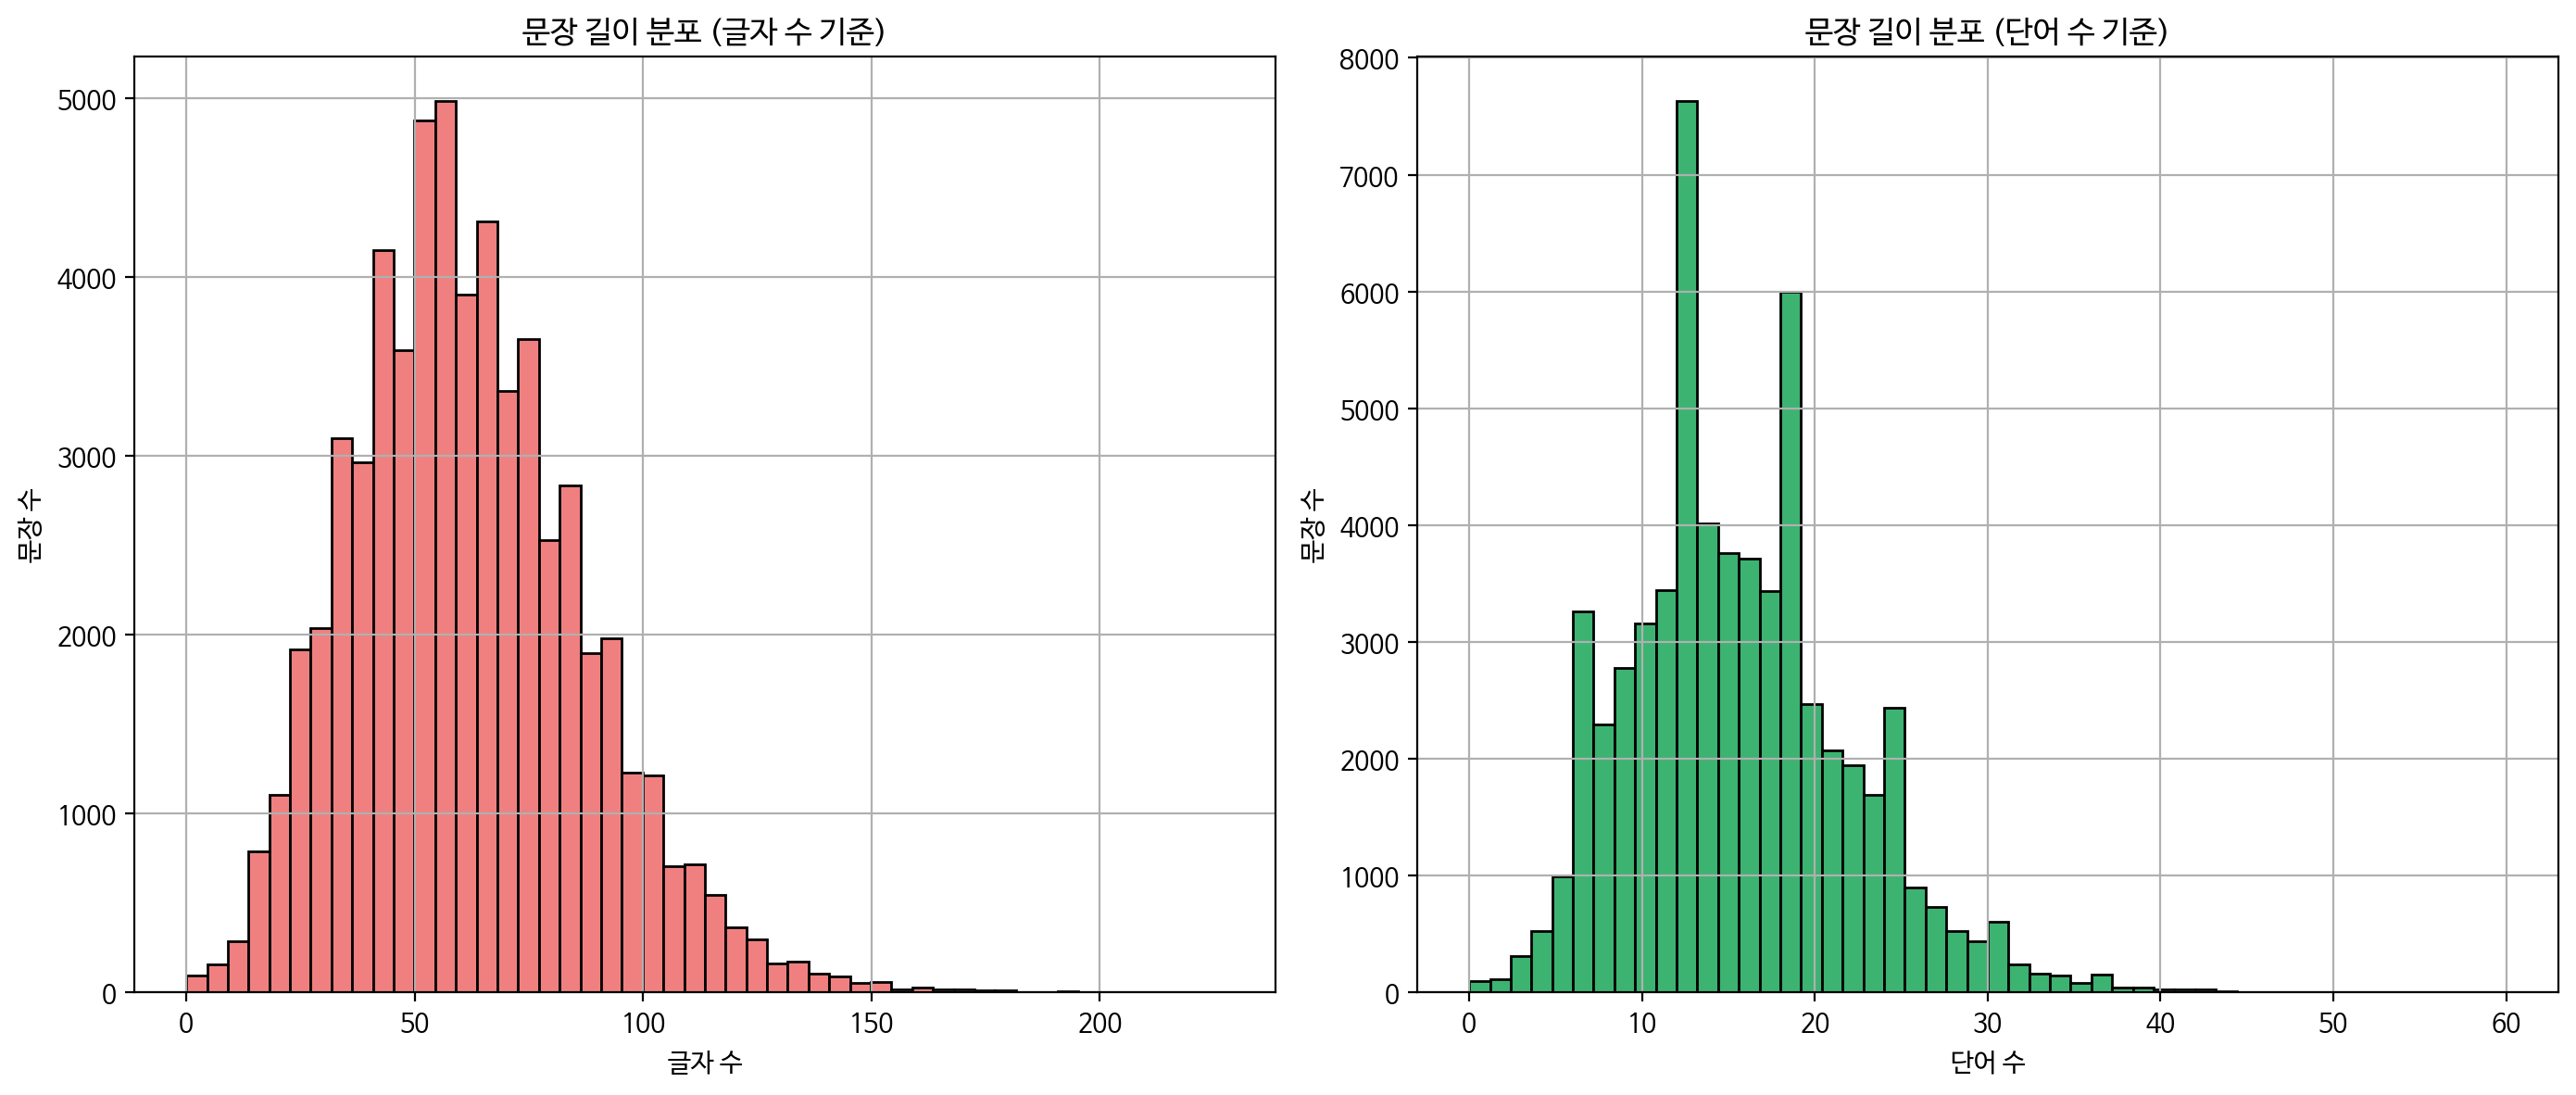

In [23]:
char_lengths = train['ko_pre'].apply(len)

word_lengths_kr = train['ko_pre'].apply(lambda x: len(x.split()))
word_lengths_kr_test = test['ko_pre'].apply(lambda x: len(x.split()))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(char_lengths, bins=50, color='lightcoral', edgecolor='black')
plt.title('문장 길이 분포 (글자 수 기준)')
plt.xlabel('글자 수')
plt.ylabel('문장 수')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(word_lengths_kr, bins=50, color='mediumseagreen', edgecolor='black')
plt.title('문장 길이 분포 (단어 수 기준)')
plt.xlabel('단어 수')
plt.ylabel('문장 수')
plt.grid(True)

plt.tight_layout()
plt.show()

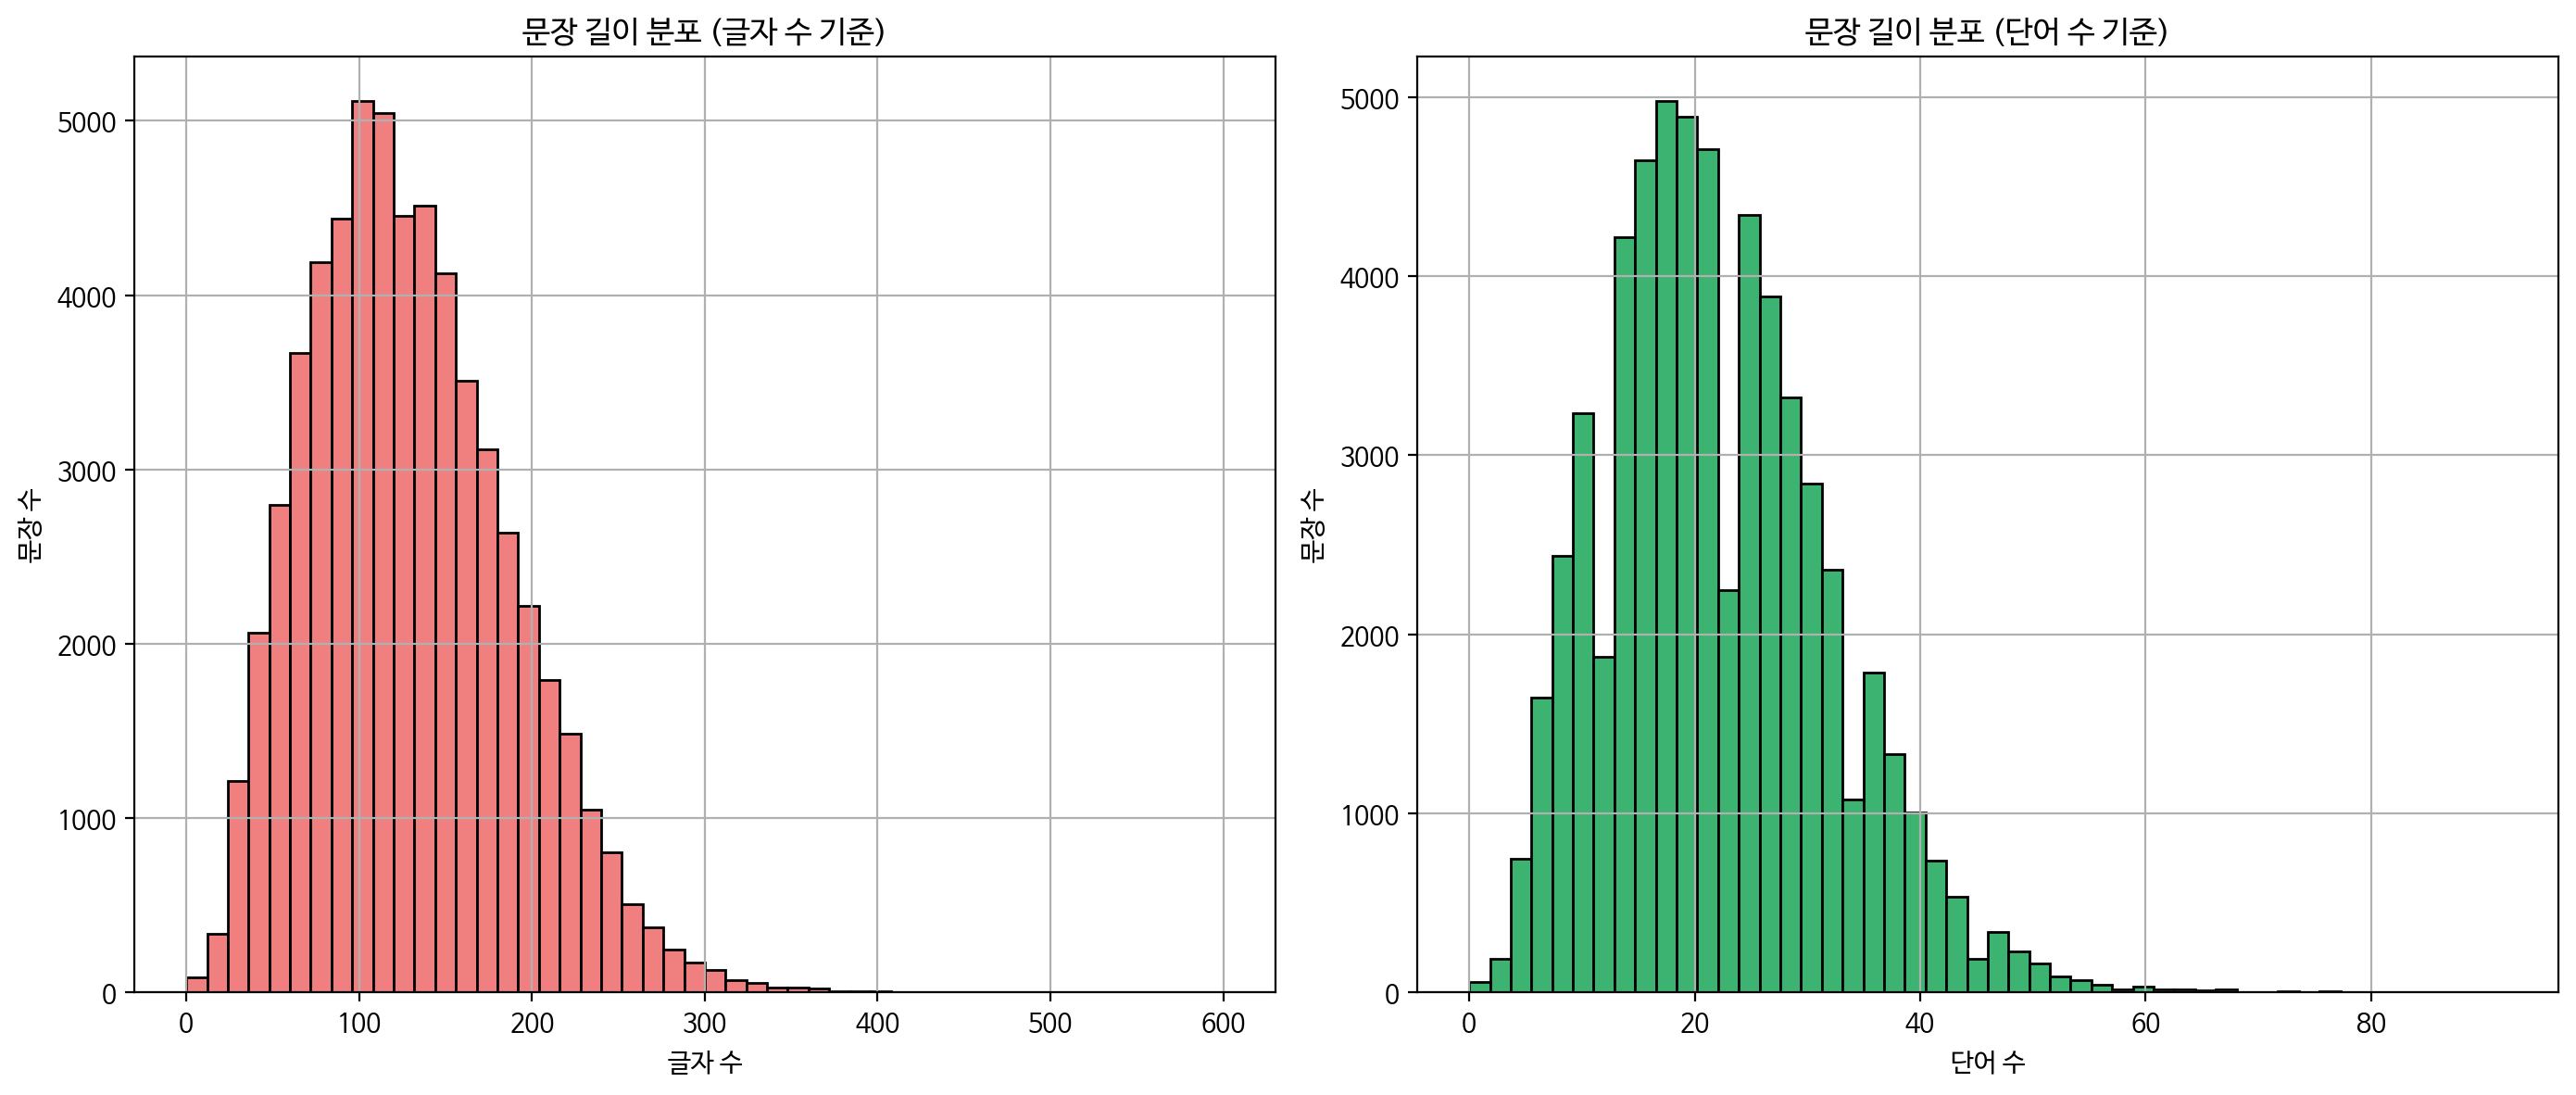

In [24]:
char_lengths = train['en_pre'].apply(len)

word_lengths_en = train['en_pre'].apply(lambda x: len(x.split()))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(char_lengths, bins=50, color='lightcoral', edgecolor='black')
plt.title('문장 길이 분포 (글자 수 기준)')
plt.xlabel('글자 수')
plt.ylabel('문장 수')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(word_lengths_en, bins=50, color='mediumseagreen', edgecolor='black')
plt.title('문장 길이 분포 (단어 수 기준)')
plt.xlabel('단어 수')
plt.ylabel('문장 수')
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
mecab = Mecab()
print(mecab.morphs("며칠 전엔 이게 됐는데 뭐 바뀌었어?"))

['며칠', '전', '엔', '이게', '됐', '는데', '뭐', '바뀌', '었', '어', '?']


In [26]:
def mecab_kr(text):
  temp_text = text.replace('<숫자>', 'N')
  tokens = mecab.morphs(temp_text)
  restored_tokens = ['<숫자>' if tok == 'N' else tok for tok in tokens]

  return restored_tokens

In [38]:
mecab_kr("<숫자>밥 먹었니?")

['<숫자>', '밥', '먹', '었', '니', '?']

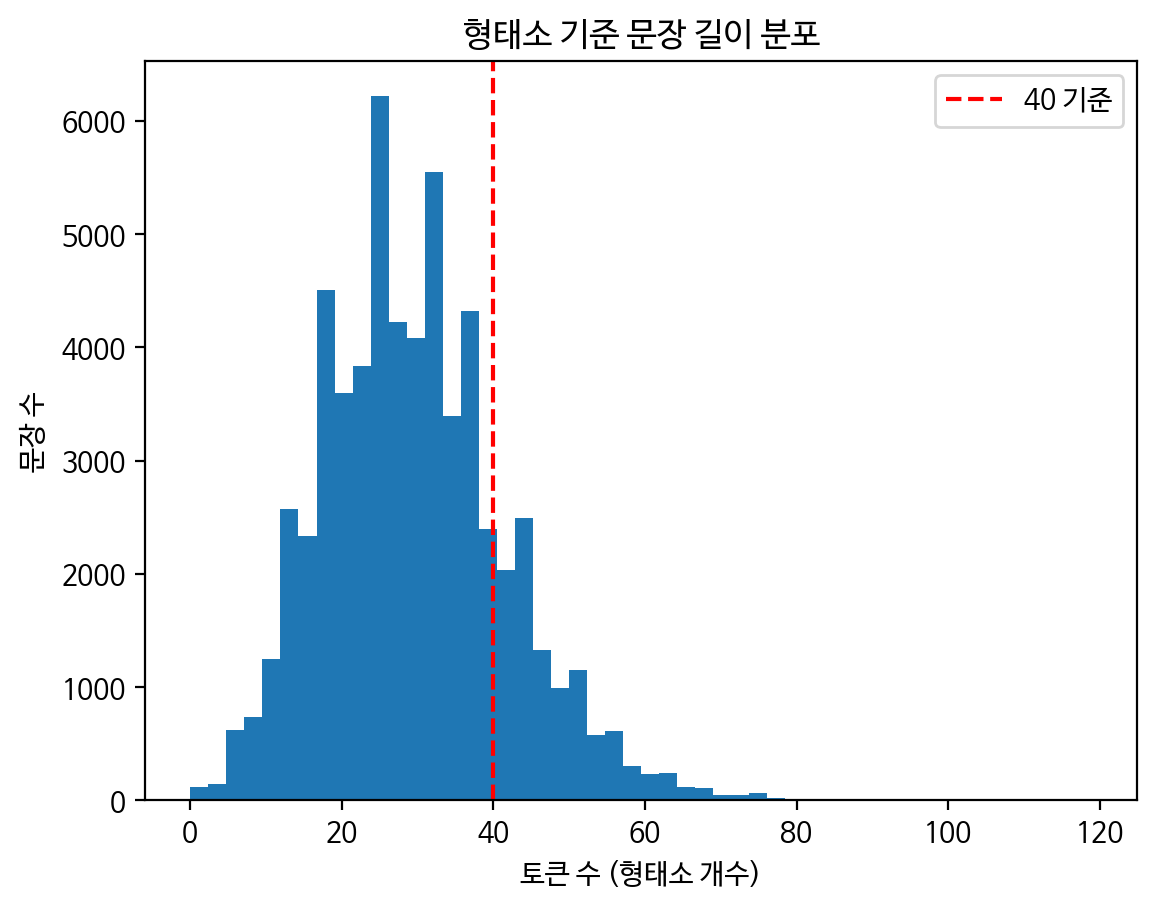

In [27]:
token_lens = train['ko_pre'].apply(lambda x: len(mecab.morphs(x)))
token_lens_test = test['ko_pre'].apply(lambda x: len(mecab.morphs(x)))

plt.hist(token_lens, bins=50)
plt.axvline(40, color='red', linestyle='--', label='40 기준')
plt.title("형태소 기준 문장 길이 분포")
plt.xlabel("토큰 수 (형태소 개수)")
plt.ylabel("문장 수")
plt.legend()
plt.show()

In [14]:
#en 기준
enc_corpus_train=[]
dec_corpus_train=[]
enc_corpus_test=[]
dec_corpus_test=[]
for i in range(len(train)):
  if len(train['en_pre'][i].split())<=40:
    enc_corpus_train.append(mecab.morphs(preprocess_kr(train['ko'][i])))
    dec_corpus_train.append(preprocess_en(train['en'][i], s_token=True, e_token=True))
for i in range(len(test)):
  if len(train['en_pre'][i].split())<=40:
    enc_corpus_test.append(mecab.morphs(preprocess_kr(test['ko'][i])))
    dec_corpus_test.append(preprocess_en(test['en'][i], s_token=True, e_token=True))

In [28]:
#ko 기준
enc_corpus_train=[]
dec_corpus_train=[]
enc_corpus_test=[]
dec_corpus_test=[]
enc_corpus_score=[]
dec_corpus_score=[]
for i in range(len(train)):
  if word_lengths_kr[i]>3 and token_lens[i]<=40:
    enc_corpus_train.append(mecab_kr(preprocess_kr(train['ko'][i])))
    dec_corpus_train.append(preprocess_en(train['en'][i], s_token=True, e_token=True))
for i in range(len(test)):
  if word_lengths_kr_test[i]>3 and token_lens_test[i]<=40:
    enc_corpus_test.append(mecab_kr(preprocess_kr(test['ko'][i])))
    dec_corpus_test.append(preprocess_en(test['en'][i], s_token=True, e_token=True))
    enc_corpus_score.append(test['ko'][i])
    dec_corpus_score.append(preprocess_en(test['en'][i], replace=True))

print(len(enc_corpus_train), len(dec_corpus_train), len(enc_corpus_test), len(dec_corpus_test))

49403 49403 1200 1200


In [29]:
def tokenize(corpus, vocab_size=None, oov_token='<OOV>'):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='',oov_token=oov_token)
  tokenizer.fit_on_texts(corpus)

  tensor = tokenizer.texts_to_sequences(corpus)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tf.convert_to_tensor(tensor), tokenizer

In [30]:
def tokenize2(corpus1,corpus2, tokenizer1, tokenizer2, max_len):
  tensor1 = tokenizer1.texts_to_sequences(corpus1)
  tensor1 = tf.keras.preprocessing.sequence.pad_sequences(tensor1, padding='post', maxlen=max_len[0], truncating='post')

  tensor2 = tokenizer2.texts_to_sequences(corpus2)
  tensor2 = tf.keras.preprocessing.sequence.pad_sequences(tensor2, padding='post', maxlen=max_len[1], truncating='post')
  return tf.convert_to_tensor(tensor1), tf.convert_to_tensor(tensor2)

In [164]:
def compute_vocab_coverage(corpus, topk_list=[1000, 2000, 5000, 8000, 10000, 20000]):
  tokenizer = Tokenizer(filters='', oov_token=None)
  tokenizer.fit_on_texts(corpus)

  word_counts = tokenizer.word_counts  # collections.OrderedDict
  sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

  total_tokens = sum([count for _, count in sorted_counts])

  print(f"총 토큰 수: {total_tokens}")
  print(f"전체 단어 수 (고유): {len(sorted_counts)}")

  cumulative = np.cumsum([count for _, count in sorted_counts])
  coverage_list = [cumulative[k-1] / total_tokens * 100 if k <= len(cumulative) else 100.0 for k in topk_list]

  for k, cov in zip(topk_list, coverage_list):
      print(f"Vocab Size = {k:5d} → Coverage: {cov:.2f}%")

  plt.figure(figsize=(8, 4))
  plt.plot(np.arange(1, len(cumulative)+1), cumulative / total_tokens * 100)
  plt.xlabel("Vocab Size (Top-N Words)")
  plt.ylabel("Coverage (%)")
  plt.title("Vocab Size vs. Token Coverage")
  plt.grid(True)
  plt.axhline(95, color='r', linestyle='--', label='95% Cutoff')
  plt.legend()
  plt.tight_layout()
  plt.show()

총 토큰 수: 1292010
전체 단어 수 (고유): 35147
Vocab Size = 10000 → Coverage: 95.94%
Vocab Size = 12000 → Coverage: 96.79%
Vocab Size = 15000 → Coverage: 97.70%
Vocab Size = 20000 → Coverage: 98.65%


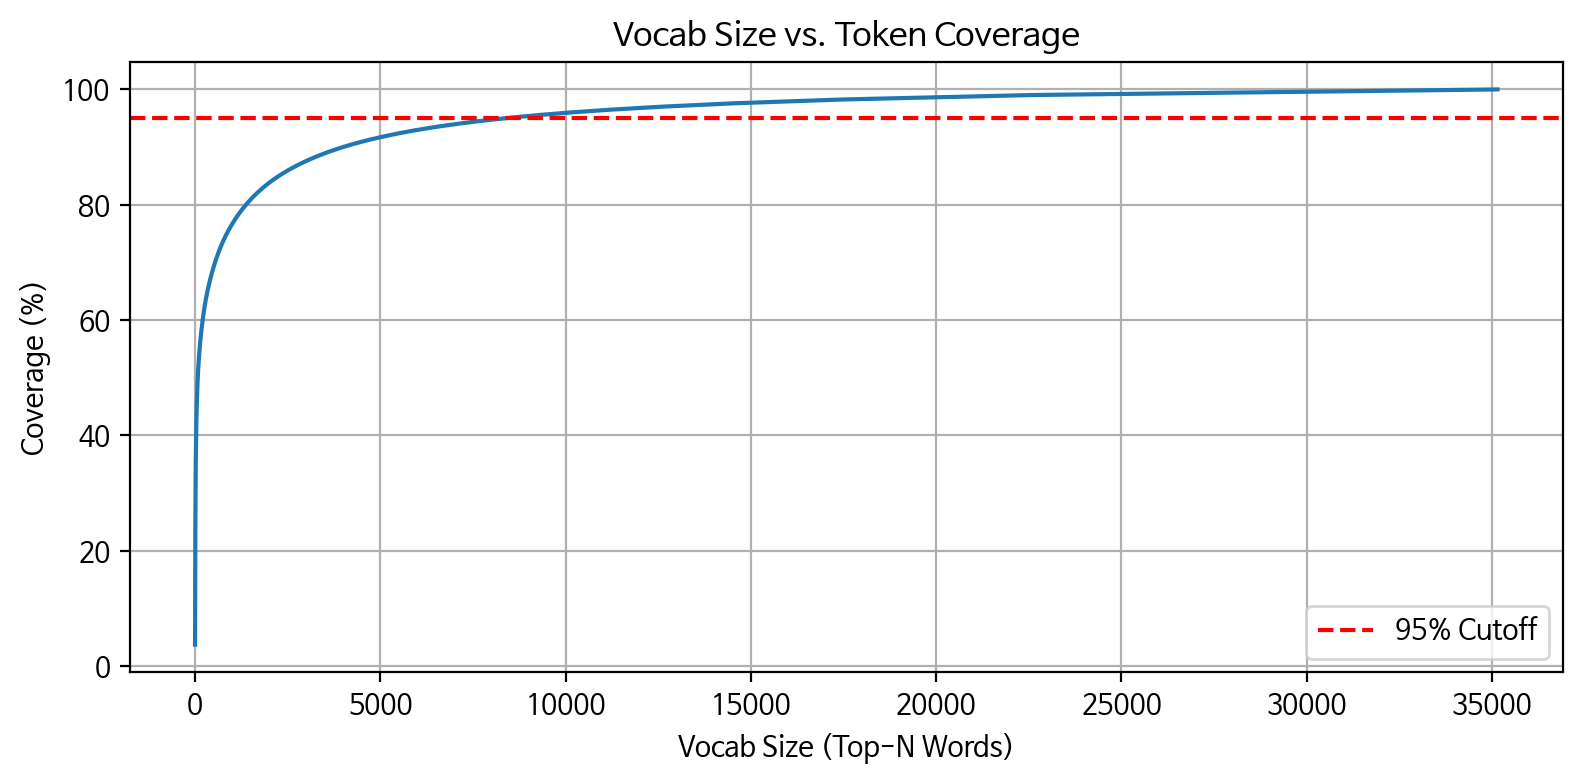

In [165]:
compute_vocab_coverage(enc_corpus_train, topk_list=[10000, 12000, 15000, 20000])

총 토큰 수: 1168691
전체 단어 수 (고유): 38623
Vocab Size = 10000 → Coverage: 95.01%
Vocab Size = 12000 → Coverage: 95.97%
Vocab Size = 15000 → Coverage: 97.01%
Vocab Size = 20000 → Coverage: 98.10%


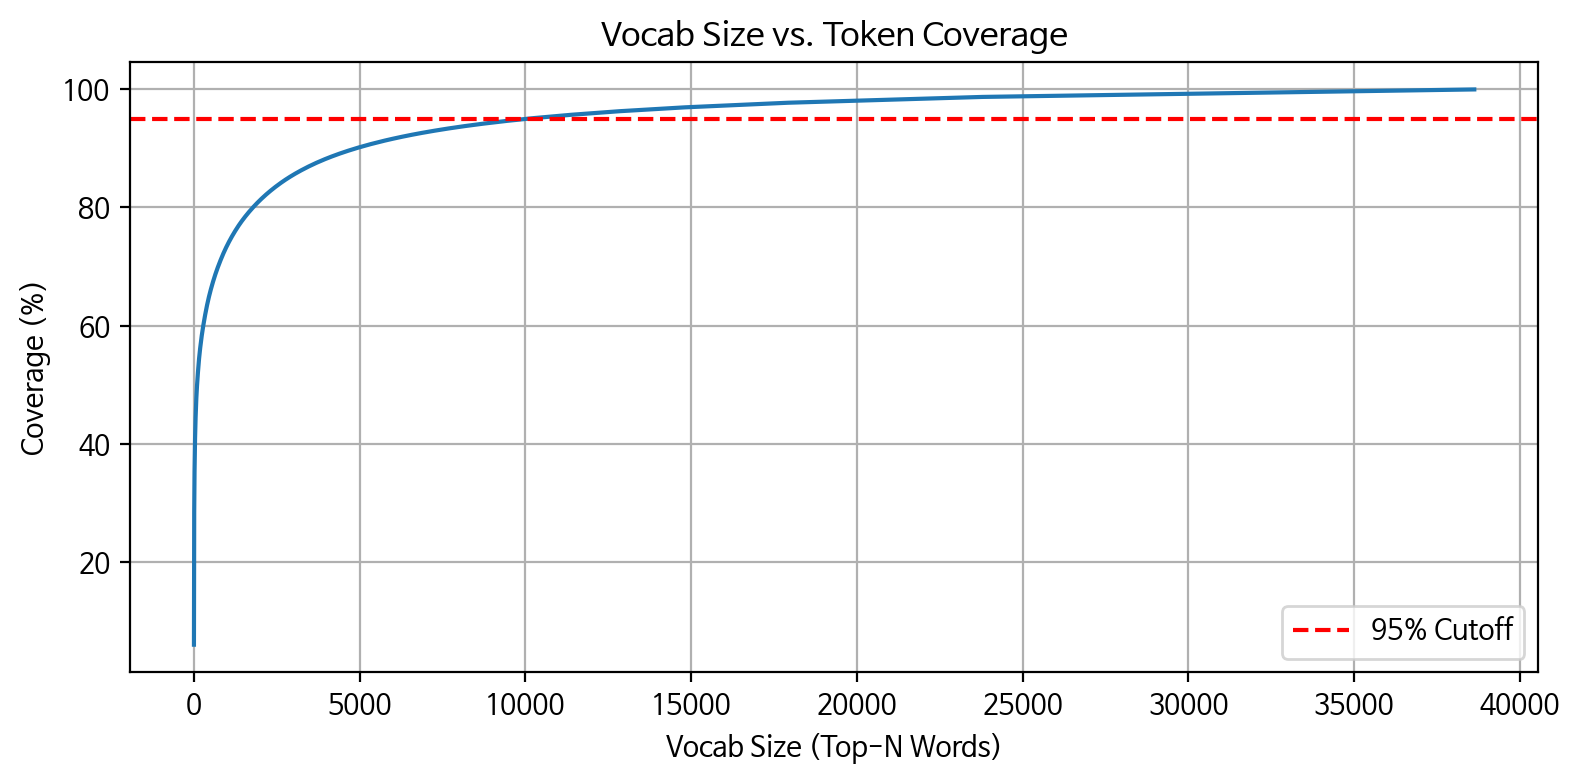

In [166]:
compute_vocab_coverage(dec_corpus_train, topk_list=[10000, 12000, 15000, 20000])

In [31]:
enc_tensor_train, enc_tokenizer=tokenize(enc_corpus_train,12000)
dec_tensor_train, dec_tokenizer=tokenize(dec_corpus_train,12000)

In [32]:
max_len=[]
max_len.append(enc_tensor_train.shape[1])
max_len.append(dec_tensor_train.shape[1])
enc_tensor_test, dec_tensor_test = tokenize2(enc_corpus_test,dec_corpus_test,enc_tokenizer,dec_tokenizer,max_len)

In [168]:
enc_tokenizer.index_word[1]

'<OOV>'

In [169]:
enc_tensor_train.shape, dec_tensor_train.shape

((52106, 40), (52106, 78))

In [35]:
enc_tensor_test.shape, dec_tensor_test.shape

(TensorShape([1272, 40]), TensorShape([1272, 78]))

In [28]:
type(enc_tensor_train)

tensorflow.python.framework.ops.EagerTensor

#2.bahdanau attention gru model

1. attention 패딩 마스크 추가
2. enc last hidden state 제대로 가져오기
3. batch_loss, 유효 토큰 개수로 나누기 및 reduce_mean에 패딩 값이 평균에 안들어가게 수정

In [33]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.w_dec = tf.keras.layers.Dense(units)
    self.w_enc = tf.keras.layers.Dense(units)
    self.w_com = tf.keras.layers.Dense(1)

  def call(self, h_enc, h_dec, mask=None):
    # h_enc: [batch, seq_len, hidden_dim]
    # h_dec: [batch, hidden_dim]

    h_enc_proj = self.w_enc(h_enc)
    h_dec_proj = self.w_dec(tf.expand_dims(h_dec, 1))

    score = self.w_com(tf.nn.tanh(h_dec_proj + h_enc_proj))

    if mask is not None:
      score -= 1e9 * tf.expand_dims(mask, -1)  # mask: 1 for pad, 0 for real

    score /= tf.math.sqrt(tf.cast(h_enc.shape[-1], tf.float32))

    attn = tf.nn.softmax(score, axis=1)

    context_vec = tf.reduce_sum(attn * h_enc, axis=1)   # (batch, seq_len, 1) * (batch, seq_len, unit)

    return context_vec, attn

In [34]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, dropout_rate=0.2):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,mask_zero=True)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.gru = tf.keras.layers.GRU(enc_units,return_sequences=True, dropout=dropout_rate)

  def call(self, x):
    out = self.embedding(x)
    out = self.dropout(out)
    out = self.gru(out)

    #mask_zero 옵션 쓰면 indexing 해도 무방
    h_enc_last = out[:, -1, :]

    return out, h_enc_last

In [ ]:
#padding인 시점의 hidden state값은 0이라 제대로 가져오려면 return_state가 필요,
#return state하면 cudnn지원이 안되서 rnn grucell로 fallback되서 시간도 느리고 output도 불필요하게 복사되서 나옴
lengths = tf.reduce_sum(tf.cast(x != 0, tf.int32), axis=1)
time_indices = lengths - 1
batch_indices = tf.range(tf.shape(out)[0])
h_enc_last = tf.gather_nd(out, tf.stack([batch_indices, time_indices], axis=1))

In [35]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units,dropout_rate=0.1):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(dec_units,
                                    return_sequences=True, dropout=dropout_rate)
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, h_dec, enc_out, enc_x):
    mask = tf.cast(tf.math.equal(enc_x, 0), tf.float32)
    context_vec, attn = self.attention(enc_out, h_dec, mask)

    out = self.embedding(x)
    out = self.dropout(out)
    out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

    out = self.gru(out, initial_state=[h_dec])
    h_dec = out[:, -1, :]
    out = tf.reshape(out, (-1, out.shape[2]))
    out = self.dropout(out)
    out = self.fc(out)

    return out, h_dec, attn

In [149]:
zero_mask = np.all(enc_tensor_train == 0, axis=1)
print("전체가 0인 시퀀스 수:", np.sum(zero_mask))
if np.any(zero_mask):
    print("예시:", enc_tensor_train[zero_mask][:3])

전체가 0인 시퀀스 수: 8
예시: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]


In [39]:
zero_mask = np.all(enc_tensor_test == 0, axis=1)
print("전체가 0인 시퀀스 수:", np.sum(zero_mask))
if np.any(zero_mask):
    print("예시:", enc_tensor_train[zero_mask][:3])

전체가 0인 시퀀스 수: 0


In [19]:
enc_tokenizer.num_words

12000

In [44]:
len(enc_tokenizer.word_index)

38001

In [57]:
import tensorflow.keras.backend as K
K.clear_session()

In [148]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = enc_tokenizer.num_words + 1
TGT_VOCAB_SIZE = dec_tokenizer.num_words + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output, sample_state  = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)
print ('Encoder Hidden State:', sample_state.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output, sample_enc)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Encoder Hidden State: (64, 1024)
decoder input1에 mask 붙어있는가? False
decoder input2에 mask 붙어있는가? True
decoder input3에 mask 붙어있는가? False


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'bahdanau_attention' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


decoder input1에 mask 붙어있는가? False
decoder input2에 mask 붙어있는가? True
decoder input3에 mask 붙어있는가? False
Decoder Output: (64, 12001)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


In [36]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  return tf.reduce_sum(loss) , tf.cast(tf.reduce_sum(mask),tf.float32)

In [37]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
  bsz = src.shape[0]
  total_loss = 0.0
  total_tokens = 0.0
  loss=0.0

  with tf.GradientTape() as tape:
    enc_out, h_enc_last = encoder(src)
    h_dec = h_enc_last

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
      pred, h_dec, _ = decoder(dec_src, h_dec, enc_out,src)
      step_loss, step_mask = loss_function(tgt[:, t], pred)

      loss += step_loss/(step_mask+1e-9)
      total_loss += step_loss
      total_tokens += step_mask
      dec_src = tf.expand_dims(tgt[:, t], 1)

  batch_loss = total_loss/total_tokens

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [38]:
class EarlyStopping:
  def __init__(self, patience=3, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.best = None
    self.wait = 0
    self.stopped_epoch = 0
    self.stop_training = False

  def on_epoch_end(self, epoch, current):
    if self.best is None or current < self.best - self.min_delta:
      self.best = current
      self.wait = 0
    else:
      self.wait += 1
      if self.wait >= self.patience:
        self.stop_training = True
        self.stopped_epoch = epoch

In [39]:
class LrScheduler:
  def __init__(self, optimizer, factor=0.5, patience=2, min_lr=1e-6, min_delta=0):
    self.optimizer = optimizer
    self.factor = factor
    self.patience = patience
    self.min_lr = min_lr
    self.min_delta = min_delta
    self.best = None
    self.wait = 0

  def on_epoch_end(self, epoch, current_val):
    if self.best is None or current_val < self.best - self.min_delta:
      self.best = current_val
      self.wait = 0
    else:
      self.wait += 1
      if self.wait >= self.patience:
        old_lr = float(tf.keras.backend.get_value(self.optimizer.learning_rate))
        new_lr = max(old_lr * self.factor, self.min_lr)
        tf.keras.backend.set_value(self.optimizer.learning_rate, new_lr)
        print(f"\nEpoch {epoch+1}: ReduceLROnPlateau reducing learning rate to {new_lr:.6f}")
        self.wait = 0

In [40]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
  bsz = src.shape[0]
  total_loss = 0.0
  total_tokens = 0.0

  with tf.GradientTape() as tape:
    enc_out, h_enc_last = encoder(src)
    h_dec = h_enc_last

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
      pred, h_dec, _ = decoder(dec_src, h_dec, enc_out,src)
      step_loss, step_mask = loss_function(tgt[:, t], pred)

      total_loss += step_loss
      total_tokens += step_mask
      dec_src = tf.expand_dims(tgt[:, t], 1)

  batch_loss = total_loss/total_tokens

  return batch_loss

In [41]:
def plot_loss_graph(train_log, test_log):
  epochs = range(1, len(train_log) + 1)

  plt.figure(figsize=(8, 5))
  plt.plot(epochs, train_log, label='Train Loss')
  plt.plot(epochs, test_log, label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Train/Test Loss per Epoch')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [42]:
def main(encoder, decoder, name):
  train_log=[]
  test_log=[]
  best_val_loss=100.0
  for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_tensor_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
      batch_loss = train_step(enc_tensor_train[idx:idx+BATCH_SIZE],
                              dec_tensor_train[idx:idx+BATCH_SIZE],
                              encoder,
                              decoder,
                              optimizer,
                              dec_tokenizer)

      total_loss += batch_loss
      t.set_description_str('Epoch %2d' % (epoch + 1))
      t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    train_log.append(total_loss.numpy())

    test_loss = 0
    idx_list = list(range(0, enc_tensor_test.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
      test_batch_loss = eval_step(enc_tensor_test[idx:idx+BATCH_SIZE],
                                  dec_tensor_test[idx:idx+BATCH_SIZE],
                                  encoder,
                                  decoder,
                                  dec_tokenizer)
      test_loss += test_batch_loss
      t.set_description_str('Test Epoch %2d' % (epoch + 1))
      t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

    avg_test_loss = test_loss.numpy() / (test_batch + 1)
    test_log.append(test_loss.numpy())

    if avg_test_loss < best_val_loss:
      best_val_loss = avg_test_loss
      encoder.save_weights(name+'encoder_best.weights.h5')
      decoder.save_weights(name+'decoder_best.weights.h5')

    earlystop.on_epoch_end(epoch, avg_test_loss)
    lr_reduce.on_epoch_end(epoch, avg_test_loss)

    if earlystop.stop_training:
      print(f"\nEarly stopping at epoch {epoch+1}")
      break

  encoder.load_weights(name + 'encoder_best.weigths.h5')
  decoder.load_weights(name + 'decoder_best.weights.h5')
  plot_loss_graph(train_log, test_log)
  return encoder, decoder

In [51]:
EPOCHS = 40
earlystop = EarlyStopping(patience=6, min_delta=0.001)
lr_reduce = LrScheduler(optimizer, factor=0.5, patience=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4)

BATCH_SIZE     = 256
SRC_VOCAB_SIZE = enc_tokenizer.num_words + 1
TGT_VOCAB_SIZE = dec_tokenizer.num_words + 1

units         = 1024
embedding_dim = 512

encoder1 = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder1 = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

ex1 = main(encoder1, decoder1, 'ex1_')

  0%|          | 0/204 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'bahdanau_attention' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

AttributeError: 'Adam' object has no attribute 'lr'

In [ ]:
EPOCHS = 100
earlystop = EarlyStopping(patience=6, min_delta=0.001)
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4, clipnorm=2.0)
lr_reduce = LrScheduler(optimizer, factor=0.5, patience=3)


BATCH_SIZE     = 256
SRC_VOCAB_SIZE = enc_tokenizer.num_words + 1
TGT_VOCAB_SIZE = dec_tokenizer.num_words + 1

units         = 1024
embedding_dim = 512

encoder1 = Encoder(SRC_VOCAB_SIZE, embedding_dim, units, dropout_rate=0.3)
decoder1 = Decoder(TGT_VOCAB_SIZE, embedding_dim, units, dropout_rate=0.2)

ex1 = main(encoder1, decoder1, 'ex1_')

  0%|          | 0/193 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'bahdanau_attention' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

#3.eval

1. OOV replace
2. bleu score

In [ ]:
def NUMreplace(mapping,inputs,enc_tokenizer,attention_weights):
  enc_num=enc_tokenizer.word_index['<숫자>']
  inputs = np.array(inputs[0])
  num_indices = np.where(inputs == enc_num)[0]
  if len(num_indices) == 0:
    return '<num_fail>'
  attn_index = np.argmax(attention_weights[num_indices])
  token = mapping.get(attn_index, '<num_fail>')

  return token

In [ ]:
def OOVreplace(oov_map,attention_weights):
  index = np.argmax(attention_weights)

  return oov_map.get(index, '<oov_fail>')

In [ ]:
def evaluate(sentence, encoder, decoder):
  attention = np.zeros((dec_tensor_train.shape[-1], enc_tensor_train.shape[-1]))
  dec_num=dec_tokenizer.word_index['<num>']
  enc_oov=enc_tokenizer.word_index['<OOV>']
  dec_oov=dec_tokenizer.word_index['<OOV>']

  sentence, mapping = preprocess_kr(sentence, replace=True)
  sentence = mecab_kr(sentence)

  inputs = enc_tokenizer.texts_to_sequences([sentence])
  inputs_id = np.array(inputs[0])
  oov_index = np.where(inputs_id == enc_oov)[0]
  oov_map = {i: sentence[i] for i in oov_index}
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                          maxlen=enc_tensor_train.shape[-1],
                                                          padding='post')

  result = ''

  enc_out, dec_hidden = encoder(inputs)

  dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

  for t in range(dec_tensor_train.shape[-1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input,dec_hidden,enc_out,inputs)

    attention_weights = tf.reshape(attention_weights, (-1, )).numpy()
    attention[t] = attention_weights

    predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

    if predicted_id ==0:
      return result, sentence, attention
    elif predicted_id ==dec_num :
      result += NUMreplace(mapping, inputs, enc_tokenizer, attention_weights) + ' '
    elif predicted_id ==dec_oov :
      result += OOVreplace(oov_map, attention_weights) + ' '
    else:
      result += dec_tokenizer.index_word[predicted_id] + ' '

    if dec_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticks(range(len(sentence)))
  ax.set_yticks(range(len(predicted_sentence)))

  ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


def translate(sentence, encoder, decoder):
  result, sentence, attention = evaluate(sentence, encoder, decoder)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention = attention[:len(result.split()), :len(sentence)]
  plot_attention(attention, sentence, result.split(' '))

#translate("커피 한잔 줄래?", encoder1, decoder1)

In [46]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# bleu_scores([[ref]],[hyp])

def clean_tokens(tokens, start_token='<start>', end_token='<end>'):
  if tokens[0] == start_token:
    tokens = tokens[1:]
  if end_token in tokens:
    tokens = tokens[:tokens.index(end_token)]
  return tokens

def bleu_scores(references, hypotheses):
  smoothie = SmoothingFunction().method1

  bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=smoothie)
  bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
  bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

  return {
      'BLEU-1': round(bleu1, 4),
      'BLEU-2': round(bleu2, 4),
      'BLEU-4': round(bleu4, 4)
  }

def scoring(hyp, refs_raw=dec_corpus_score):
  assert len(refs_raw) == len(hyp), "참조와 예측의 개수가 다릅니다."
  total_sample = len(refs_raw)

  refs_raw = [ref.split() for ref in refs_raw]
  hyp = [h.split() for h in hyp]

  refs_raw = [clean_tokens(ref) for ref in refs_raw]
  hyp = [clean_tokens(h) for h in hyp]

  meteor_scores = []
  for i in range(total_sample):
    meteor_scores.append(meteor_score([refs_raw[i]], hyp[i]))
  meteor_scores = np.array(meteor_scores)
  meteor_mean = np.mean(meteor_scores)

  refer = [[ref] for ref in refs_raw]
  bleu = bleu_scores(refer, hyp)

  return meteor_scores, meteor_mean, bleu

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:
refs = [
    ['<start>', 'I', 'like', 'coffee', '<end>'],
    ['<start>', 'She', 'is', 'reading', 'a', 'book', '<end>'],
    ['<start>', 'We', 'watched', 'a', 'movie', 'together', '<end>']
]

hyps = [
    ['<start>', 'I', 'love', 'coffee', '<end>'],                     # 의미 비슷
    ['<start>', 'She', 'reads', 'a', 'book', '<end>'],               # 시제만 다름
    ['<start>', 'We', 'saw', 'a', 'film', '<end>']                   # 의미 같음 but 어휘 다름
]

print(scoring(hyps, refs))

(np.float64(0.5665154950869237), {'BLEU-1': 0.5306, 'BLEU-2': 0.2352, 'BLEU-4': 0.0711})


#4.Luong attention

1. concat은 bahdanau랑 유사하고, dot과 general은 dense matrix하나 차이이기 때문에 general만 실험하고 dot은 mode만 남김
2. global attention과 local attention 비교

In [47]:
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, units, method='general'):
    super(LuongAttention, self).__init__()
    self.method = method
    if method == 'general':
      self.W_combine = tf.keras.layers.Dense(units)

  def call(self, H_encoder, H_decoder, mask=None):
    if self.method == 'general':
      WH = self.W_combine(H_encoder) # (batch, seq_len, units) * (units, units) -> (batch, seq_len, units)
    elif self.method == 'dot':
      WH = H_encoder

    H_decoder = tf.expand_dims(H_decoder, 1)
    alignment = tf.matmul(WH, tf.transpose(H_decoder, [0, 2, 1])) # (batch, seq_len, units) * (batch, units ,1)

    if mask is not None:
      alignment -= 1e9 * tf.expand_dims(mask, -1)
    attention_weights = tf.nn.softmax(alignment, axis=1)

    attention_weights = tf.squeeze(attention_weights, axis=-1)
    context_vector = tf.matmul(tf.expand_dims(attention_weights,1), H_encoder)

    return context_vector, attention_weights

In [48]:
class LocalAttention(tf.keras.layers.Layer):
  def __init__(self, units, window_size, method='general'):
    super(LocalAttention, self).__init__()
    self.units = units
    self.D = window_size
    self.method = method
    if method == 'general':
      self.W = tf.keras.layers.Dense(units)

    self.Wp = tf.keras.layers.Dense(units,activation='tanh')
    self.vp = tf.keras.layers.Dense(1, activation='sigmoid',use_bias=False)

  def call(self, H_encoder, h_dec, mask=None):
    # H_encoder: (batch, Tx, units)
    # h_dec: (batch, units)
    max_len = tf.shape(H_encoder)[1]

    if mask is not None:
      Tx = tf.reduce_sum(tf.cast(tf.equal(mask, 0), tf.float32), axis=1)
    else :
      Tx = tf.cast(max_len, tf.float32)

    # pt = Tx * sigmoid(vp^T tanh(Wp h_dec)), pt만 batch차원으로 따로 구함.
    pt = self.vp(self.Wp(h_dec))
    pt = tf.squeeze(pt, -1)
    pt = Tx * pt # (batch,)

    if self.method == 'general':
      WH = self.W(H_encoder)
    elif self.method == 'dot':
      WH = H_encoder

    h_dec = tf.expand_dims(h_dec, 1)  # (batch, 1, units)
    alignment = tf.matmul(WH, h_dec, transpose_b=True) #(batch, seq_len, 1)
    score = tf.squeeze(alignment, -1)  # (batch, seq_len)

    # gaussian(j) = exp( - (j - pt)^2 / (2 * sigma^2) ), soft window
    sigma = self.D / 2.0
    pos = tf.range(max_len, dtype=tf.float32)[tf.newaxis, :]     # (1, seq_len)
    pt_exp = pt[:, tf.newaxis]                                   # (batch, 1)

    gauss = tf.exp(- ((pos - pt_exp) ** 2) / (2 * sigma ** 2))  # (batch, seq_len)
    score = score * gauss                                       # (batch, seq_len)

    if mask is not None:
      score -= mask  * 1e9

    attention_weights = tf.nn.softmax(score, axis=-1)      # (batch, seq_len)

    context_vector = tf.matmul(tf.expand_dims(attention_weights,1), H_encoder)   # (batch, 1, units)

    return context_vector, attention_weights

In [49]:
class Decoder_luong(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units,dropout_rate=0.1):
    super(Decoder_luong, self).__init__()
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(dec_units,
                                    return_sequences=True, dropout=dropout_rate)
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dropout2 = tf.keras.layers.Dropout(0.1)

    self.attention = LuongAttention(self.dec_units) #같아야 함

    self.w_ss = tf.keras.layers.Dense(self.dec_units) #달라도 됨
    self.w_cs = tf.keras.layers.Dense(self.dec_units)

  def call(self, x, h_dec, enc_out, enc_x):
    out = self.embedding(x)
    out = self.dropout(out)
    out = self.gru(out, initial_state=[h_dec]) # (batch, 1, units)
    h_dec = out[:, -1, :]

    mask = tf.cast(tf.math.equal(enc_x, 0), tf.float32)
    context_vec, attn = self.attention(enc_out, h_dec, mask)

    out = self.w_ss(out)
    out = self.dropout(out)
    context_vec = self.w_cs(context_vec)
    context_vec = self.dropout2(context_vec)

    logits = self.fc(tf.nn.tanh(out + context_vec))
    logits = tf.squeeze(logits, axis=1)

    return logits, h_dec, attn

In [50]:
class Decoder_luong_local(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, window_size, dropout_rate=0.1):
    super(Decoder_luong_local, self).__init__()
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(dec_units,
                                    return_sequences=True, dropout=dropout_rate)
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

    self.attention = LocalAttention(self.dec_units, window_size) #같아야 함

    self.w_ss = tf.keras.layers.Dense(self.dec_units) #달라도 됨
    self.w_cs = tf.keras.layers.Dense(self.dec_units)

  def call(self, x, h_dec, enc_out, enc_x):
    out = self.embedding(x)
    out = self.gru(out, initial_state=[h_dec]) # (batch, 1, units)
    h_dec = out[:, -1, :]

    mask = tf.cast(tf.math.equal(enc_x, 0), tf.float32)
    context_vec, attn = self.attention(enc_out, h_dec, mask)

    out = self.w_ss(out)
    out = self.dropout(out)
    context_vec = self.w_cs(context_vec)

    logits = self.fc(tf.nn.tanh(out + context_vec))
    logits = tf.squeeze(logits, axis=1)

    return logits, h_dec, attn

In [26]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = 12000 + 1
TGT_VOCAB_SIZE = 12000 + 1

units         = 1024
embedding_dim = 512

encoder2 = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder_luong(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output, sample_state  = encoder2(sample_enc)

print ('Encoder Output:', sample_output.shape)
print ('Encoder Hidden State:', sample_state.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output, sample_enc)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Encoder Hidden State: (64, 1024)
out (64, 1, 1024)
con (64, 1, 1024)
out (64, 1, 1024)
con (64, 1, 1024)
Decoder Output: (64, 12001)
Decoder Hidden State: (64, 1024)
Attention: (64, 30)


In [ ]:
import tensorflow.keras.backend as K
K.clear_session()

EPOCHS = 60
earlystop = EarlyStopping(patience=5, min_delta=0.001)
lr_reduce = LrScheduler(optimizer, factor=0.5, patience=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4)

BATCH_SIZE     = 256
SRC_VOCAB_SIZE = enc_tokenizer.num_words + 1
TGT_VOCAB_SIZE = dec_tokenizer.num_words + 1

units         = 1024
embedding_dim = 512

encoder2 = Encoder(SRC_VOCAB_SIZE, embedding_dim, units,dropout_rate=0.2)
decoder2 = Decoder_luong(TGT_VOCAB_SIZE, embedding_dim, units,dropout_rate=0.2)

ex2 = main(encoder2, decoder2, 'ex2_')

  0%|          | 0/193 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'luong_attention' (of type LuongAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [51]:
import tensorflow.keras.backend as K
K.clear_session()

EPOCHS = 40
earlystop = EarlyStopping(patience=6, min_delta=0.001)
lr_reduce = LrScheduler(optimizer, factor=0.5, patience=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4)

BATCH_SIZE     = 128
SRC_VOCAB_SIZE = enc_tokenizer.num_words + 1
TGT_VOCAB_SIZE = dec_tokenizer.num_words + 1

units         = 1024
embedding_dim = 512

encoder3 = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder3 = Decoder_luong_local(TGT_VOCAB_SIZE, embedding_dim, units, window_size=10)

ex3 = main(encoder3, decoder3, 'ex3_')

  0%|          | 0/386 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'local_attention' (of type LocalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


KeyboardInterrupt: 

In [67]:
def inference(encoder,decoder, df=enc_corpus_score):
  hyp=[]
  attns=[]
  for i in df:
    result, _, attn = evaluate(i, encoder, decoder)
    hyp.append(result)
    attns.append(attn)
  return hyp, attns

In [ ]:
hyp1 = inference(ex1[0],ex1[1])
hyp2 = inference(ex2[0],ex2[1])
hyp3 = inference(ex3[0],ex3[1])

score1 = scoring(hyp1)
score2 = scoring(hyp2)
score3 = scoring(hyp3)

In [68]:
hyp1 = inference(encoder1, decoder1)

In [76]:
hyp1[0][0]

'some people are talking to fear that the government is <oov_fail> to the country and allow many people to consider many people <end> '

In [80]:
score1 = scoring(hyp1[0])

In [83]:
top_n = 10
top_indices = np.argsort(score1[0])[-top_n:][::-1]

print("Top METEOR scores:", score1[0][top_indices])

Top METEOR scores: [0.57241379 0.48387097 0.48076923 0.46875    0.45979381 0.45660377
 0.45631641 0.44829932 0.39893617 0.38271605]


In [87]:
for i in top_indices:
  print("meteor score: ", score1[0][i])
  print("한국어: ", enc_corpus_score[i])
  print("reference: ", dec_corpus_score[i])
  print("translate: ", hyp1[0][i])
  print("--------------------")

meteor score:  0.5724137931034483
한국어:  이밖에 경찰관 2명이 부상했다.
reference:  2 other police officers were wounded in the attack
translate:  <num_fail> were wounded in the attack <end> 
--------------------
meteor score:  0.4838709677419355
한국어:  다우존스산업지수는 전날에 비해 2.5%(277포인트) 넘게 올랐다.
reference:  the dow jones industrial average gained 277 points to end the day more than 5 higher
translate:  the dow jones industrial average jumping 5 points on the record <end> 
--------------------
meteor score:  0.48076923076923084
한국어:  현재 다우지수는 14포인트 상승했습니다.
reference:  right now the dow is up 14 points
translate:  the dow is down <num_fail> points <end> 
--------------------
meteor score:  0.46875
한국어:  그는 또 “나는 축복 받았다”고 덧붙였다.
reference:  i was very blessed
translate:  he was very sorry <end> 
--------------------
meteor score:  0.4597938144329897
한국어:  이번 지진은 리히터 규모 6.4의 강진이었다.
reference:  the quake had a magnitude of 4 the service said
translate:  the quake was a magnitude of <num_fail> <end> 
-----------

과적합이 심하다.
1. units, embedding dim 조절
2. dropout과 weight decay

oov/num replace는 기본적으로 source 문장의 oov/num에서 attention score가 높게 나올 것을 가정하였는데 학습이 충분치 않거나 가정이 틀려서 애초에 oov/num token을 참조하지 못한다.

다우존스 예문을 보면 attention score가 7.863에서만 높아서 7.863만 복사해오는 것을 확인할 수 있다.

additive attention 위주.
transformer와 비교했을 때 비선형성도 부족해 보임.
batchnorm

Bahdanau에 비해 Luong이 attention score 계싼에도 비선형성이 없고 bahdanau는 encoder 정보를 직접적으로 참고해서 score를 구하는데 비해 loung는 gru 결과를 가지고 score를 구하는 점에서 decoder 초기 부담이 심하다.

또한 bahanau와 luoung은 decoder gru input shape이 달라서 unit 개수를 다른 기준으로 설정할 필요가 있다.

attention score scaling 도입하면 너무 sharp하게 나오는것이 완화되어 학습에 도움될 여지가 있다.

scaling안하면 softmax 분포가 sharp해서 거의 one-hot 형태라 1제외하고는 grad가 잘 안흐름

scaling하면
→ 다양한 encoder state들 간의 상대적 차이를 더 유효하게 드러내줌

→ decoder가 한두 개 위치만 보지 않고 여러 위치를 시험해볼 여유가 생김, 학습 기회



/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'bahdanau_attention' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Input: ['다우', '존스', '산업', '평균', '지수', '가', '<숫자>', '으로', '<숫자>', '포인트', '하락', '하', '여', '년', '내', '최저', '를', '기록', '했', '다']
Predicted translation: the dow jones industrial average 7,683 points or 7,683 points to 7,683 7,683 points <end> 


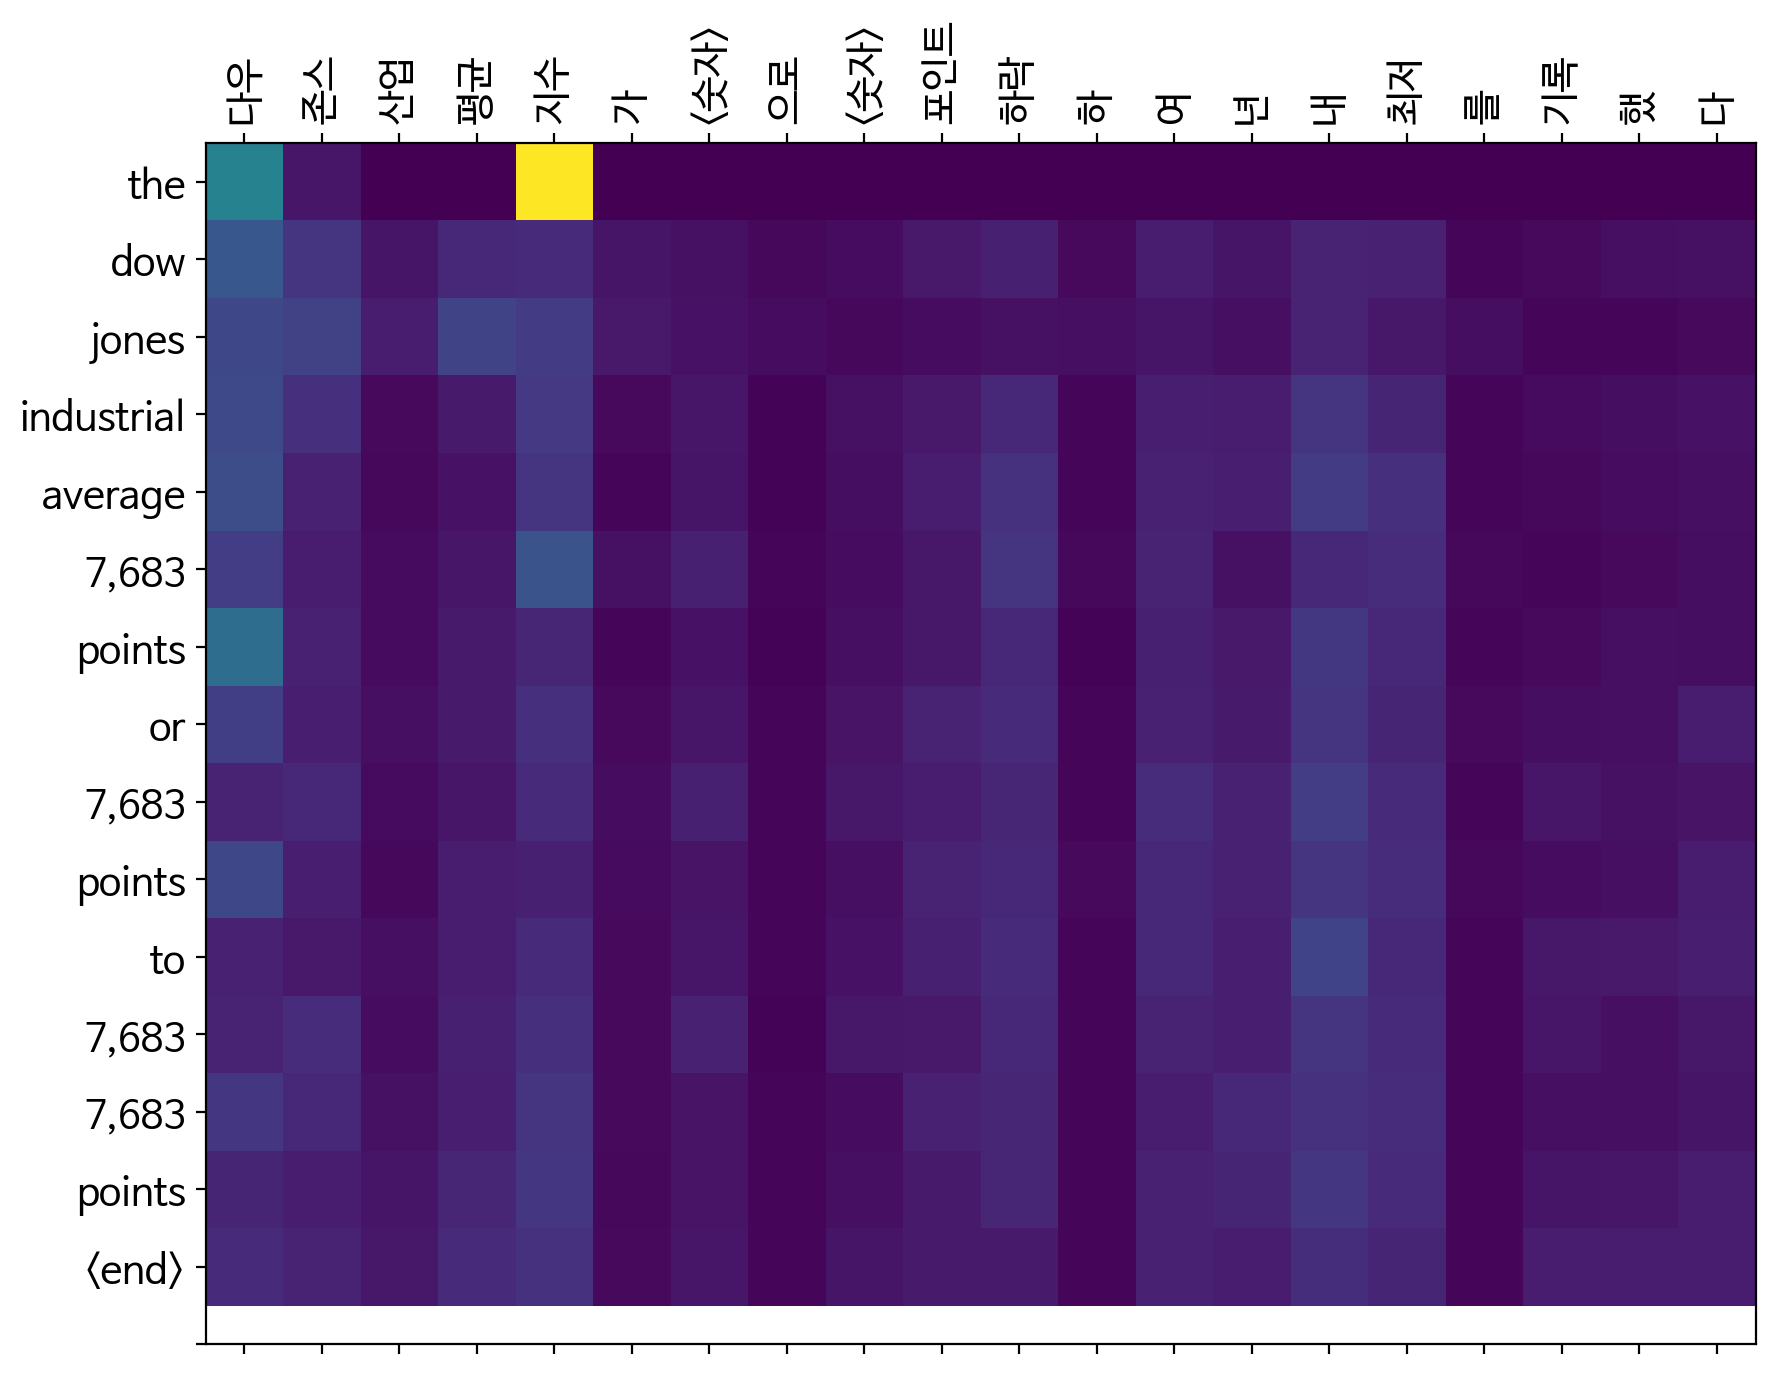

In [88]:
translate('다우 존스 산업 평균 지수가 7,683.13으로 189.02 포인트 하락하여 4년내 최저를 기록했다.',encoder1, decoder1)